## Logistic regression v/s Bayesian classifier
#### In this question of the assignment, we are asked to implement a logistic regression model and a Bayesian classifier starting by training it on a dataset of size 5 and increasing it incremently by 5. 
Firstly, in Bayesian classifier, we shall adopt a generative (probabilistic) approach in which we model the class-conditional densities p(x|Ck), as well as the class priors p(Ck), and then use these to compute posterior probabilities p(Ck|x) through Bayes’ theorem.
However, in logistic regression, we use generalised linear models to directly get the posterior probability of classes, and aim to learn the parameters by maximum likelihood.

We first begin by implementing a Bayesian classifier. This begins by reading the data.

In [37]:
library(ggplot2)# for plotting functions.
library(reshape2) # for melt and cast functions
library(mvtnorm) #Computes multivariate normal and t probabilities, quantiles, random deviates and densities.

In [38]:
train<-read.csv('Task1E_train.csv')
test<-read.csv('Task1E_test.csv')

In [39]:
test.data <- test[,1:2]
test.label <-  test[,3]

In [40]:
train.data <- train[,1:2]
train.label <-  train[,3]

We plot the distribution for labels.

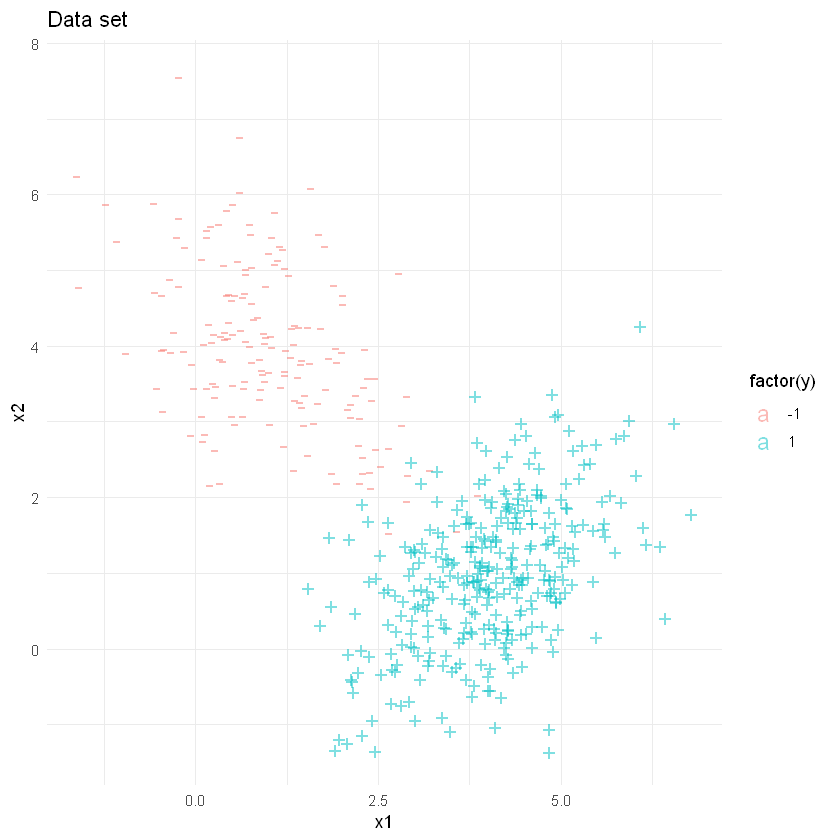

In [41]:
ggplot(data=train, aes(x=x1, y=x2, color=factor(y), label=ifelse(y==+1, '+', '-'))) +
geom_text(size = 5, alpha=0.5) +
ggtitle ('Data set') +
theme_minimal()

### Steps to Build A Bayesian Classifier
These are the steps to build a bayesian Classifier:
<ol>
	<li>Calculate the class priors $p(\mathcal{C}_k)$ based on the relative number of training data in each class,</li>
	<li>Calculate the class means $\mu_k$, class covariance matrices $\mathbf{S}_k$ and shared covariance matrix $\Sigma$ using the training data,</li>
	<li>Using the estimated PDF function, calculate $p(x_n|\mathcal{C}_k)$ for each data point and each class,</li>
	<li>For each test sample, find the class label $\mathcal{C}_k$ that maximizes the $p(\mathcal{C}_k)p(x_n|\mathcal{C}_k)$,</li>
</ol>


**Step 1:** Let's start with calculating the class probabilities and compare the obtained values with the real class probabilites.


In [42]:
#dataframe to store Missclassificatio Rate 
miss <- data.frame('Size'=double(), 'Test'=double(),'Model'=character())
for (i in  seq(5, nrow(train.data), by=5))
{    
    #consider increment in 5 data points everytime
    train_label =train.label[1:i]
    train_data =train.data[1:i,]
   
    
    # Step 1: Calcualte Class probabilities:
    p0.hat <- sum(train_label==+1)/nrow(train_data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- 1 - p0.hat # or simply 1 - p1.hat
    
     
    # Step 2: Calcualte Class means:
    mu0.hat <- colMeans(train_data[train_label==+1,])
    mu1.hat <- colMeans(train_data[train_label==-1,])
    
    
    # Step 2 : Calcualte class covariance matrices:
    sigma0.hat <- var(train_data[train_label==+1,])
    sigma1.hat <- var(train_data[train_label==-1,])
  
    
    
    # Step2: Calculate shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
  
    # Step 3 : calculate Posterior Probability:
    posterior0 <- p0.hat*dmvnorm(x=train_data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train_data, mean=mu1.hat, sigma=sigma.hat)
    
    
    # Step 4 : calculate predictionsbased on Posterior Probability:
    train.predict <- ifelse(posterior0 > posterior1, +1, -1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), +1, -1)

    # calculate Misscalssification rates:
    
    error<-(sum(test.label!=test.predict)/nrow(test.data)*100)
    # store it in a dataframe2
    de <- list('Size'=i, 'Test'=error,'Model'='BC')
    miss<-rbind(miss,de, stringsAsFactors=FALSE)
    

 
}

In [44]:
head(miss,10)

Size,Test,Model
5,68.4,BC
10,1.4,BC
15,1.8,BC
20,1.8,BC
25,2.4,BC
30,1.6,BC
35,2.2,BC
40,2.4,BC
45,2.4,BC
50,2.4,BC


We now implement a logistic regression model. 
## Steps to Build a Logistic Regression
Taking the following steps is neccesseary to build a logistic regression:
<ol>
	<li>Implement sigmoid function $\sigma(\pmb{w}.\mathbf{x})$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping criterion $\epsilon$.</li>
	<li>Repeat the followings until the improvement becomes negligible (i.e., $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})| \lt \epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta (\sigma(\pmb{w}.\mathbf{x}) - t_n) \pmb{x}_n$</li>
</ol>
</li>
</ol>
</li>
</ol>

In the followings, we implement each of these steps for every batch of training data


Auxiliary functions for predict and cost.

In [45]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X) # if greater than 0.5 class 1 else class 0
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

**Step 1 (Sigmoid):** We define our sigmoid functions.


In [46]:
# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

**Step 2:** Here, we use SGD to learn the weight vector. Note that there are two loops. In the outter loop, we shuffle the samples and then start the inner loop. In the inner loop, we visit the training samples one by one and update the weights accordingly.

In [49]:
for (i in  seq(5, nrow(train.data), by=5))
{    
# consider increment in 5 data points everytime
train.index <- 1:i
train.data <- train[train.index,-3]
train.label <- train[train.index,3]
train.len <- i
# Intialialize the parameter
tau.max <- 1000 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.01 # a threshold on the cost (to terminate the process)
tau <- 1 # iteration counter
terminate <- FALSE

## Just a few name/type conversion to make the rest of the code easy to follow
X <- as.matrix(train.data) # rename just for conviniance
T <- ifelse(train.label==c0,0,1) # rename just for conviniance

W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

# project data using the sigmoid function (just for convenient)
Y <- sigmoid(W[1,],X)

costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
costs[1, 'cost'] <- cost(W[1,],X,T, c0)

while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost:
        costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.999
    }
}
# Done!
costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

# the  final result is:
w <- W[tau,]

    
    error<-sum(predict(w,test.data,c0,c1)!=test.label)/nrow(test.data)*100
    de <- list('Size'=i, 'Test'=error,'Model'='LR')
    miss<-rbind(miss,de, stringsAsFactors=FALSE)
    
     
   }

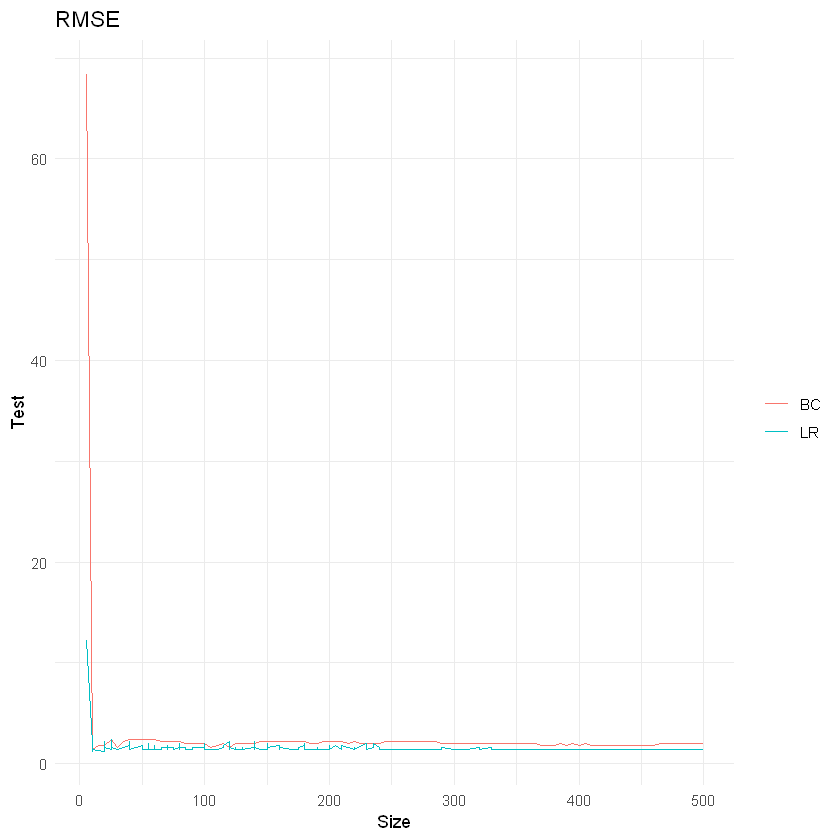

In [50]:
ggplot(data=miss, aes(x=Size, y=Test, color=Model)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("RMSE")

### We can see as the size of the dataset increases, the test error decreases for both the classifiers. There is a little uncertainty in test error around logistic regression as it flickers a lot as the size of the dataset increases but has a lower error rate as compared to Bayesian classifier however the bayesian classifier is more certain as the error rate doesn't flicker as much.
### When the dataset is very small we can use logistic regression. However, as the size of the dataset increases, to be more certain about our predictions, we may use a Bayesian classifier but if we intend to just minimize the error rate, we can use the logistic regression.
### When the size of the dataset is small, we would use logistic regression over bayesian classifier. This is due to the fact that a Bayesian classifier, Suppose the dimension of data point  x is denoted by D. Then, in the generative model we need D(D+1)/2 parameters for the (shared) covariance matrix, 2D parameters for the two means, and 1 parameter for the class prior p(C1); this gives a total of D(D+5)/2+1 parameters which grows quadratically with D. However, we only need D parameters for a discriminative model. Thus, due to a large number of parameters, this will lead to a decrease in bias and the model will overfit as in the case of the Bayesian classifier. However as the size of the dataset increases, the logistic regression model flickers a lot in its error rate due to the limited number of parameters it requires and thus leading to a less flexible model causing underfitting. Thus, a bayesian classifier works well when we have a large dataset and want to be certain abou the predictions. But if we care only about the error rate, then we can go with a logistic regression model.